# 母婴产品销售情况分析

项目背景：母婴用品是淘宝的热门购物类目，随着国家鼓励二胎、三胎政策的推进，会进一步促进了母婴类目商品的销量。与此年轻一代父母的育儿观念也发生了较大的变化，因此中国母婴电商市场发展形态也越来越多样化。随之引起各大母婴品牌更加激烈的争夺，越来越多的母婴品牌管窥到行业潜在的商机，纷纷加入母婴电商，行业竞争越来越激烈。

分析目的：帮助在线商家针对不同的时间节点和场景做出不同的销售和运营管理策略，帮助商家提高销量和营业额、减少经营成本。

## 1. 数据预处理

Baby Goods Info Data数据集包括两个csv文件：
+ (sample)sam_tianchi_mum_baby.csv 包含了消费者在淘宝和天猫提供的900+个孩子的生日和性别
+ (sample)sam_tianchi_mum_baby_trade_history.csv 包含淘宝消费者的母婴用品的消费记录

### 1.1 数据读取与概览

In [1]:
source_data_path = "./source_data/"

In [2]:
data_baby_info_path = source_data_path + "(sample)sam_tianchi_mum_baby.csv"
data_trade_info_path = source_data_path + "(sample)sam_tianchi_mum_baby_trade_history.csv"

In [3]:
# 使用pandas读取csv数据
import pandas as pd
data_baby_info = pd.read_csv(data_baby_info_path)
data_trade_info = pd.read_csv(data_trade_info_path)

In [4]:
# 查看数据详情
print(data_baby_info.info())
print(data_trade_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   953 non-null    int64
 1   birthday  953 non-null    int64
 2   gender    953 non-null    int64
dtypes: int64(3)
memory usage: 22.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29971 entries, 0 to 29970
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     29971 non-null  int64 
 1   auction_id  29971 non-null  int64 
 2   cat_id      29971 non-null  int64 
 3   cat1        29971 non-null  int64 
 4   property    29827 non-null  object
 5   buy_mount   29971 non-null  int64 
 6   day         29971 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.6+ MB
None


**字段解释：**

**data_baby_info**
+ user_id：用户id，具有唯一性，用来识别购买用户，一个用户ID代表一个用户；
+ irthday：出生日期，用户对应填写的婴儿出生日期，可以从购买时间来算出婴儿实际年龄；
+ ender：性别（0 男性；1 女性；2 未知）。

**data_trade_info**
+ user_id：用户ID，具有唯一性，用来识别购买用户，一个用户ID代表一个用户；
+ auction_id：购买行为编号，也可以理解为订单编号，一次交易成交或者交易关闭都是一个购买行为编号；  
+ cat_id：商品种类ID（小类），比如【母婴】下面有【童装】这个大类，【童装】类目下有【儿童外套】这个品类，然后每一款商品都对应唯一的商品种类ID；  
+ cat1：商品是属于哪个种类（大类），比如一款幼童夹克外套是属于童装这个大类的；  
+ property：商品属性或者说商品参数，比如一款幼童夹克外套的商品参数有，品牌方面：ZARA；适用年龄：12个月 18个月 2岁；图案：纯色；风格：休闲等等；（已去除）  
+ buy_mount：购买数量，也可以说这个订单里有几件商品；  
+ day：购买时间，就是用户在哪个时间点付款完成。

### 1.2 数据清洗

#### 缺失值处理

1. data_baby_info

In [5]:
# 检查null值
data_baby_info.isnull().sum()

user_id     0
birthday    0
gender      0
dtype: int64

data_baby_info中每个字段都没有空值

2. data_trade_info

In [6]:
data_trade_info.isnull().sum()

user_id         0
auction_id      0
cat_id          0
cat1            0
property      144
buy_mount       0
day             0
dtype: int64

property字段的解释为商品属性，由于分析过程中使用到商品属性的意义不大，所以可以直接将该字段删除

In [7]:
# 删除property字段
data_trade_info = data_trade_info.drop(columns=["property",])
data_trade_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29971 entries, 0 to 29970
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   user_id     29971 non-null  int64
 1   auction_id  29971 non-null  int64
 2   cat_id      29971 non-null  int64
 3   cat1        29971 non-null  int64
 4   buy_mount   29971 non-null  int64
 5   day         29971 non-null  int64
dtypes: int64(6)
memory usage: 1.4 MB


#### 异常值处理

1. data_trade_info

通过字段来看，可能会有异常值的字段可能会出现在buy_mount、day字段。buy_mount的数值应该适当，day日期应该在淘宝平台成立之后。

**检查buy_mount值是否存在异常值**

In [8]:
# 检查buy_mount值是否存在异常值
data_trade_info.buy_mount.describe()

count    29971.000000
mean         2.544126
std         63.986879
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      10000.000000
Name: buy_mount, dtype: float64

一般情况下，一次性购买10000件商品事件几乎不可能发生。一般取标准差(std)3倍以内的数据作为正常区间。标准差向下取整为63，所以正常区间为[1, 63\*3]=[1, 189]

In [9]:
# 过滤掉购买商品数量大于189和小于1的记录
data_trade_info = data_trade_info[(data_trade_info.buy_mount >= 1) & (data_trade_info.buy_mount <= 189)]
data_trade_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29940 entries, 0 to 29970
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   user_id     29940 non-null  int64
 1   auction_id  29940 non-null  int64
 2   cat_id      29940 non-null  int64
 3   cat1        29940 non-null  int64
 4   buy_mount   29940 non-null  int64
 5   day         29940 non-null  int64
dtypes: int64(6)
memory usage: 1.6 MB


过滤后还剩下29940条记录

**检查day是否在淘宝平台成立之后**

In [10]:
print(data_trade_info[(data_trade_info.day <= 20030510)].sum())

user_id       0.0
auction_id    0.0
cat_id        0.0
cat1          0.0
buy_mount     0.0
day           0.0
dtype: float64


可见全部记录的日期都在淘宝成立日期（2003年5月10日）之后

同时可以发现，日期字段的数据类型是int64，将其转换为datetime类型

In [11]:
data_trade_info['day'] = pd.to_datetime(data_trade_info.day.astype('str'))
data_trade_info.day.describe()

count                            29940
mean     2014-01-16 16:49:15.030060032
min                2012-07-02 00:00:00
25%                2013-06-20 00:00:00
50%                2014-03-05 12:00:00
75%                2014-09-09 00:00:00
max                2015-02-05 00:00:00
Name: day, dtype: object

2. data_baby_info

在data_baby_info中的性别字段存在未知（数值为2）的值，应该过滤掉

In [12]:
data_baby_info = data_baby_info[data_baby_info.gender != 2]
data_baby_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 927 entries, 0 to 952
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   927 non-null    int64
 1   birthday  927 non-null    int64
 2   gender    927 non-null    int64
dtypes: int64(3)
memory usage: 29.0 KB


同时，可以发现birthday字段的数据类型为int64，应该将其转换为datetime型

In [13]:
data_baby_info['birthday'] = pd.to_datetime(data_baby_info.birthday.astype('str'))
data_baby_info.birthday.describe()

count                              927
mean     2012-03-04 16:37:16.893203712
min                1984-06-16 00:00:00
25%                2011-02-09 12:00:00
50%                2012-08-07 00:00:00
75%                2013-09-26 12:00:00
max                2015-08-15 00:00:00
Name: birthday, dtype: object

竟然还有1984年出生的婴儿，应该过滤掉。淘宝平台诞生于2003年，网购的消费习惯多形成于2010年前后。

In [14]:
data_baby_info = data_baby_info[data_baby_info.birthday >= '2010-01-01']
data_baby_info.birthday.describe()

count                              798
mean     2012-11-01 04:10:49.624060160
min                2010-01-05 00:00:00
25%                2011-10-17 18:00:00
50%                2012-11-25 00:00:00
75%                2013-11-23 06:00:00
max                2015-08-15 00:00:00
Name: birthday, dtype: object

过滤后还剩下798条记录。

**添加新的列**

因为后续需要基于年、季、月来分析数据变化趋势，故为了方便，将年、季、月三个字段加入到data_trade_info表中

In [15]:
data_trade_info['year'] = data_trade_info.day.dt.year
data_trade_info['quarter'] = data_trade_info.day.dt.quarter
data_trade_info['month'] = data_trade_info.day.dt.month
data_trade_info.head()

,user_id,auction_id,cat_id,cat1,buy_mount,day,year,quarter,month
0,786295544,41098319944,50014866,50022520,2,2014-09-19,2014,3,9
1,532110457,17916191097,50011993,28,1,2013-10-11,2013,4,10
2,249013725,21896936223,50012461,50014815,1,2013-10-11,2013,4,10
3,917056007,12515996043,50018831,50014815,2,2014-10-23,2014,4,10
4,444069173,20487688075,50013636,50008168,1,2014-11-03,2014,4,11


## 2. 数据分析

从年、季、月、商品类目（一级和二级）、用户性别等多个维度对数据进行分析和可视化

### 2.1 销量整体情况分析
从年、季、月、天来对购买量进行分析

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

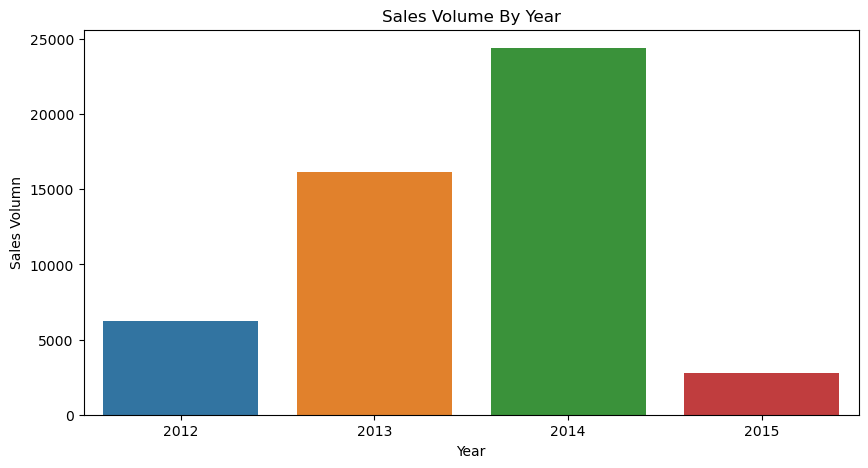

In [17]:
# 按年查看销售趋势
year_stats = data_trade_info.groupby(by='year')['buy_mount'].sum()

plt.figure(figsize=(10, 5))
sns.barplot(x=year_stats.index, y=year_stats.values)

plt.title("Sales Volume By Year")
plt.xlabel("Year")
plt.ylabel("Sales Volumn")
plt.show()

由于数据时间跨度为2012年7月到2015年2月。其中2012年和2015年数据不完整，只有2013和2014两个完整年份，且趋势符合逐年上升趋势。

下面以季度为单位来观察销售数据：

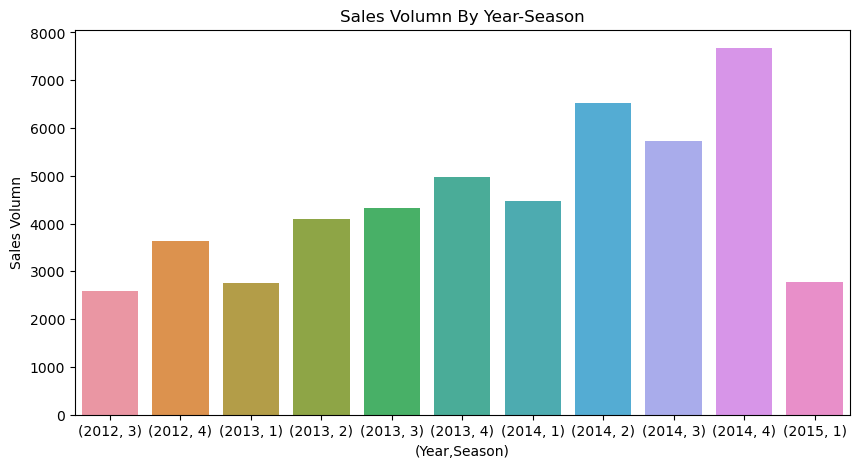

In [18]:
# 各年季度销量情况
year_quarter_stats = data_trade_info.groupby(by=['year', 'quarter'])['buy_mount'].sum()

plt.figure(figsize=(10, 5))
x_list = ['(' + str(idx[0]) + ", " + str(idx[1]) + ')' for idx in year_quarter_stats.index]
y_list = [int(value) for value in year_quarter_stats.values]
sns.barplot(x=x_list, y=y_list)
plt.title("Sales Volumn By Year-Season")
plt.xlabel("(Year,Season)")
plt.ylabel("Sales Volumn")
plt.show()

1. 2015年第1季度的数据不完整，不能反映出真实的销量情况；
2. 从图中可以看出，每年的第1季度的销量是最低的，第4季度的销量是最高的；

通过购物经验可知，每年的第1季度正逢春节，快递停运，每年的第4季度正逢双十一和双十二打折活动，猜想第1季度销量下降可能是因为春节快递停运，第4季度销量增加是因为打折活动影响

接下来以月为单位来观察销售数据：

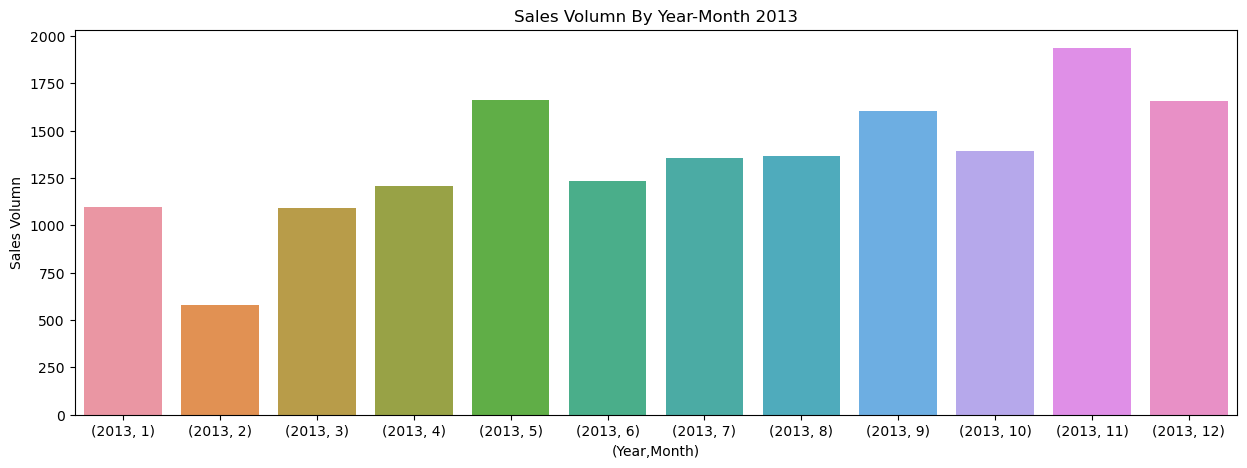

In [19]:
# 根据年月分组
year_month_stats = data_trade_info[data_trade_info.year == 2013].groupby(by=['year', 'month'])['buy_mount'].sum()

plt.figure(figsize=(15, 5))
x_list = ['(' + str(idx[0]) + ", " + str(idx[1]) + ')' for idx in year_month_stats.index]
y_list = [int(value) for value in year_month_stats.values]
sns.barplot(x=x_list, y=y_list)

plt.title("Sales Volumn By Year-Month 2013")
plt.xlabel("(Year,Month)")
plt.ylabel("Sales Volumn")
plt.show()

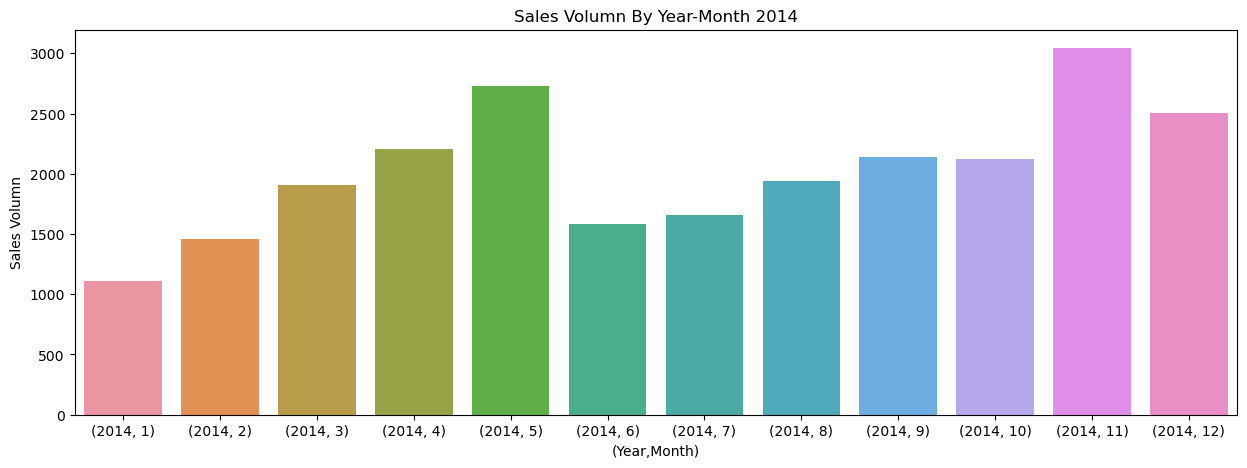

In [24]:
year_month_stats = data_trade_info[data_trade_info.year == 2014].groupby(by=['year', 'month'])['buy_mount'].sum()

plt.figure(figsize=(15, 5))
x_list = ['(' + str(idx[0]) + ", " + str(idx[1]) + ')' for idx in year_month_stats.index]
y_list = [int(value) for value in year_month_stats.values]
sns.barplot(x=x_list, y=y_list)

plt.title("Sales Volumn By Year-Month 2014")
plt.xlabel("(Year,Month)")
plt.ylabel("Sales Volumn")
plt.show()

+ 2013年春节假期：2013/2/9-2013/2/15
+ 2014年春节假期：2014/1/31-2014/2/6

2013年2月份、2014年1月份为全年销量最低，与春节假期相符合，初步验证了关于春节假期影响销量的猜想；同时每年的11月份的销量均位于当年的销量顶峰，初步验证了关于双十一打折影响销量的猜想。

下面以天为单位来观察销售数据：

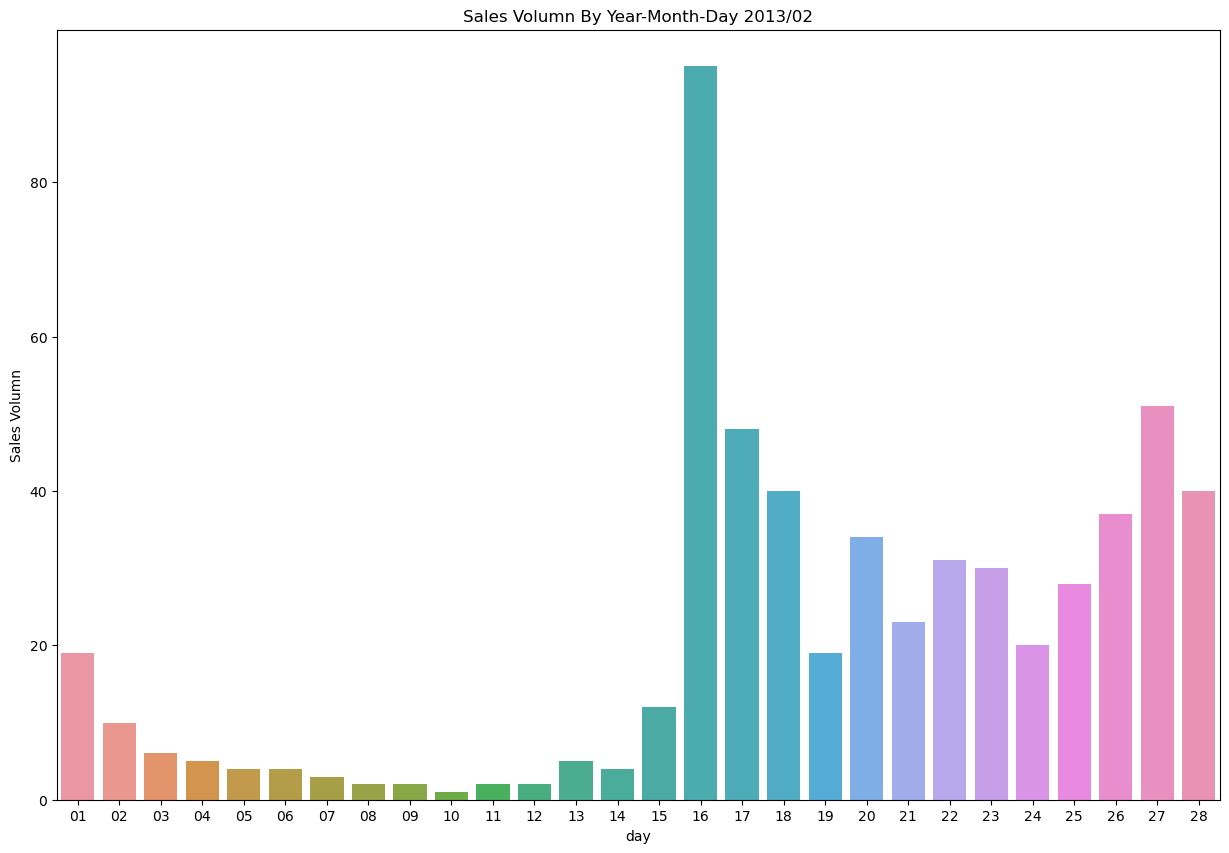

In [20]:
# 2013年2月数据
year_month_day_stats = data_trade_info[(data_trade_info.year == 2013)&(data_trade_info.month == 2)].groupby(by=['year', 'month', 'day'])['buy_mount'].sum()
plt.figure(figsize=(15, 10))
x_list = [str(idx[2])[8:10] for idx in year_month_day_stats.index]
y_list = [int(value) for value in year_month_day_stats.values]
sns.barplot(x=x_list, y=y_list)

plt.title("Sales Volumn By Year-Month-Day 2013/02")
plt.xlabel("day")
plt.ylabel("Sales Volumn")
plt.show()

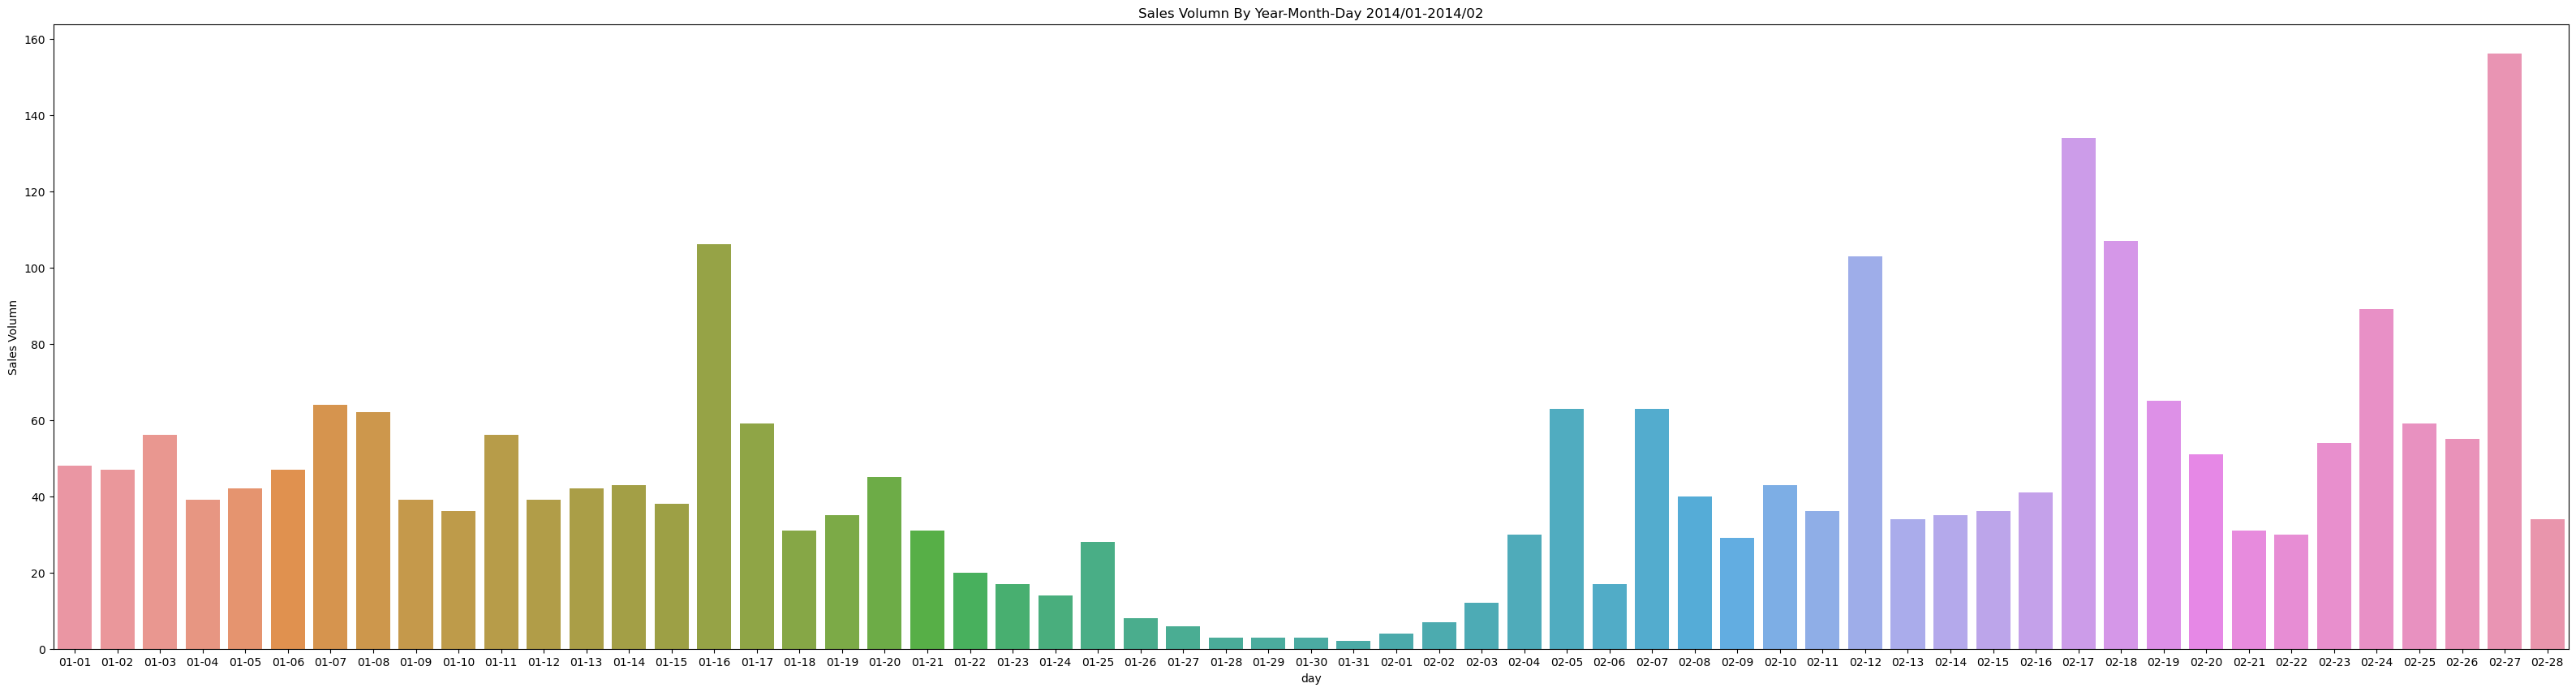

In [21]:
# 2014年1-2月数据
year_month_day_stats = data_trade_info[(data_trade_info.year == 2014)&((data_trade_info.month == 1)|(data_trade_info.month == 2))].groupby(by=['year', 'month', 'day'])['buy_mount'].sum()
plt.figure(figsize=(40, 10))
x_list = [str(idx[2])[5:10] for idx in year_month_day_stats.index]
y_list = [int(value) for value in year_month_day_stats.values]
sns.barplot(x=x_list, y=y_list)

plt.title("Sales Volumn By Year-Month-Day 2014/01-2014/02")
plt.xlabel("day")
plt.ylabel("Sales Volumn")
plt.show()

+ 2013年春节假期：2013/2/9-2013/2/15
+ 2014年春节假期：2014/1/31-2014/2/6

可见，在春节假期期间，销量处于极低水平，可以证明春节假期影响销量的假设是正确的。

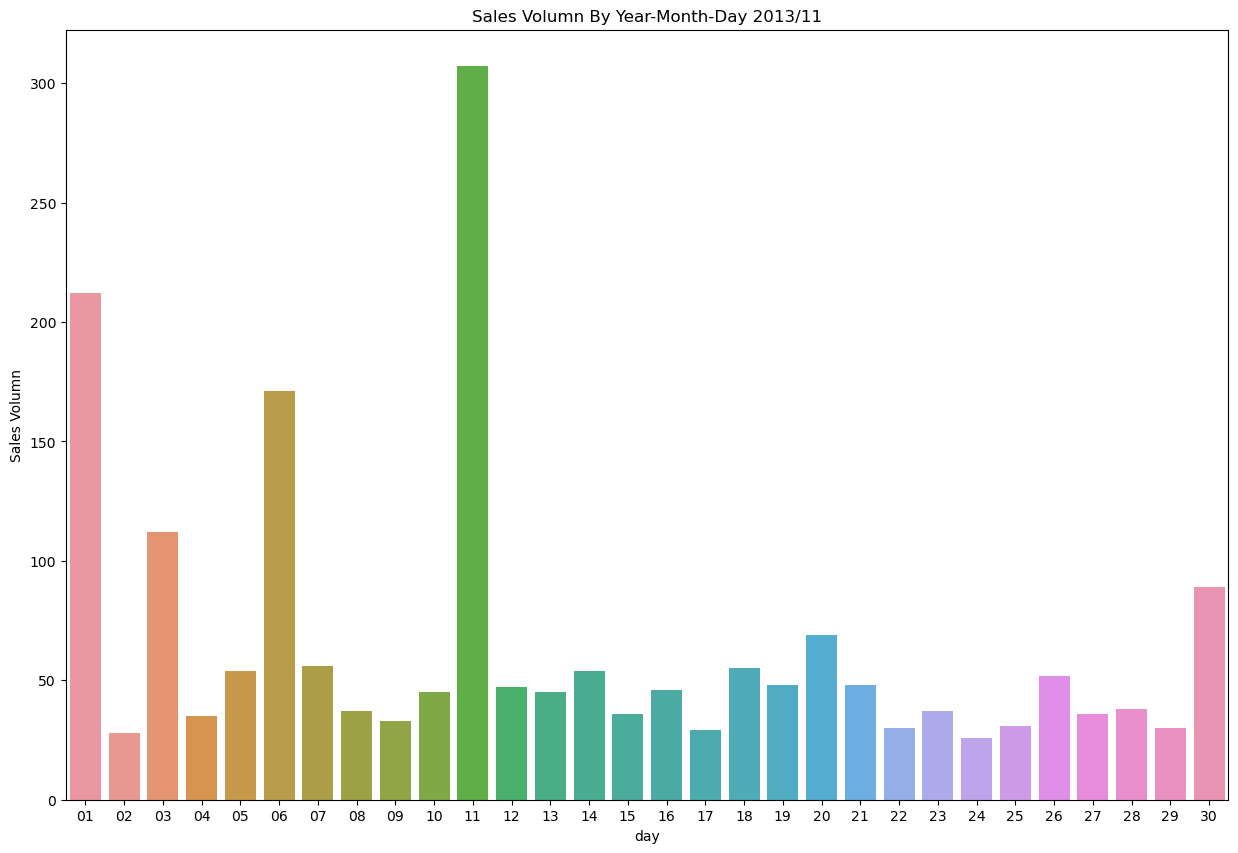

In [22]:
# 2013年11月数据
year_month_day_stats = data_trade_info[(data_trade_info.year == 2013)&(data_trade_info.month == 11)].groupby(by=['year', 'month', 'day'])['buy_mount'].sum()
plt.figure(figsize=(15, 10))
x_list = [str(idx[2])[8:10] for idx in year_month_day_stats.index]
y_list = [int(value) for value in year_month_day_stats.values]
sns.barplot(x=x_list, y=y_list)

plt.title("Sales Volumn By Year-Month-Day 2013/11")
plt.xlabel("day")
plt.ylabel("Sales Volumn")
plt.show()

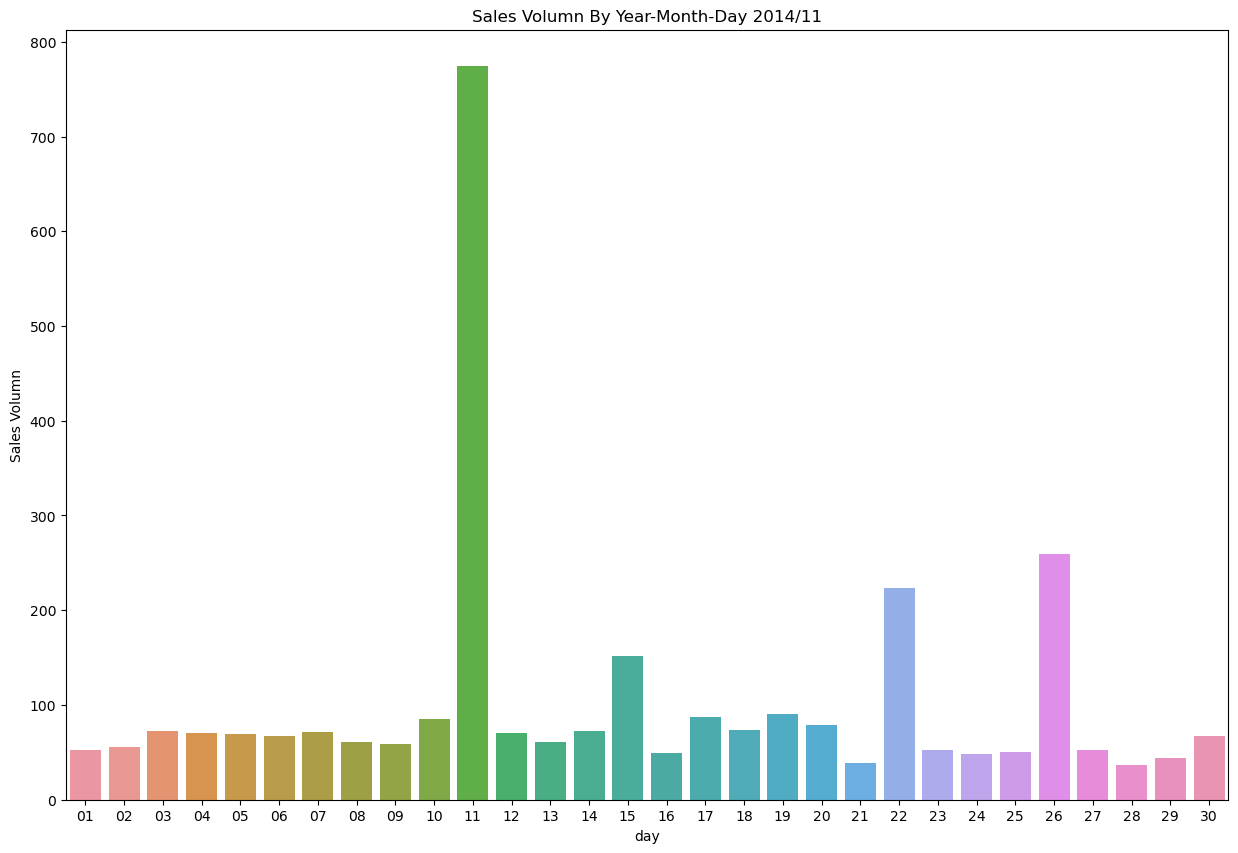

In [23]:
# 2014年11月数据
year_month_day_stats = data_trade_info[(data_trade_info.year == 2014)&(data_trade_info.month == 11)].groupby(by=['year', 'month', 'day'])['buy_mount'].sum()
plt.figure(figsize=(15, 10))
x_list = [str(idx[2])[8:10] for idx in year_month_day_stats.index]
y_list = [int(value) for value in year_month_day_stats.values]
sns.barplot(x=x_list, y=y_list)

plt.title("Sales Volumn By Year-Month-Day 2014/11")
plt.xlabel("day")
plt.ylabel("Sales Volumn")
plt.show()

可见，在双十一当天，销量处于极高水平，可以证明双十一打折影响销量的假设是正确的。

### 2.2 各类产品销售情况分析

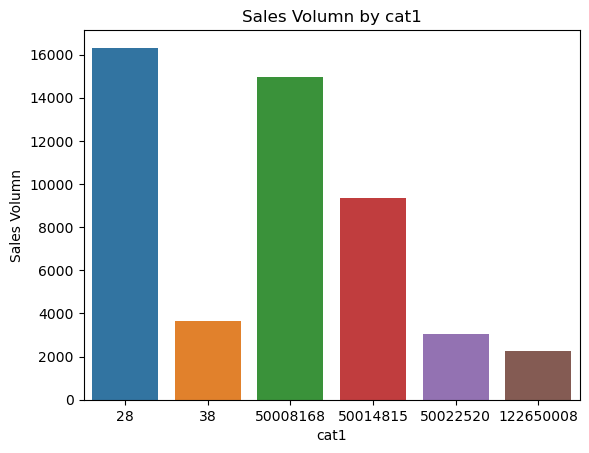

In [26]:
# 商品大类销售情况分析
cat1_stats = data_trade_info.groupby(by="cat1")["buy_mount"].sum()
sns.barplot(x=cat1_stats.index, y=cat1_stats.values)
plt.title("Sales Volumn by cat1")
plt.xlabel("cat1")
plt.ylabel('Sales Volumn')
plt.show()

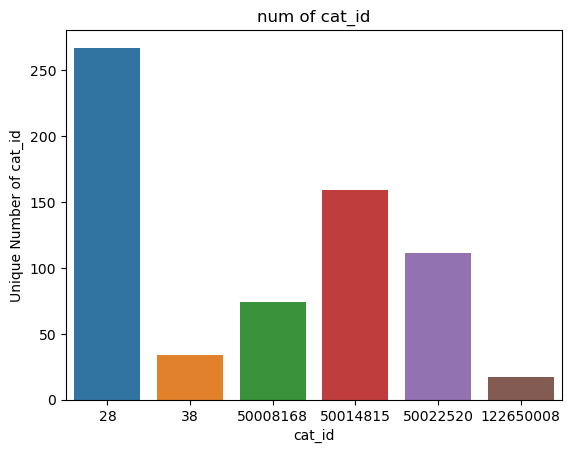

In [27]:
# 计算每个大类下面的小类数目
cat_id_stats = data_trade_info.groupby(by="cat1")["cat_id"].nunique()
sns.barplot(x=cat_id_stats.index, y=cat_id_stats.values)
plt.title("num of cat_id")
plt.xlabel("cat_id")
plt.ylabel("Unique Number of cat_id")
plt.show()

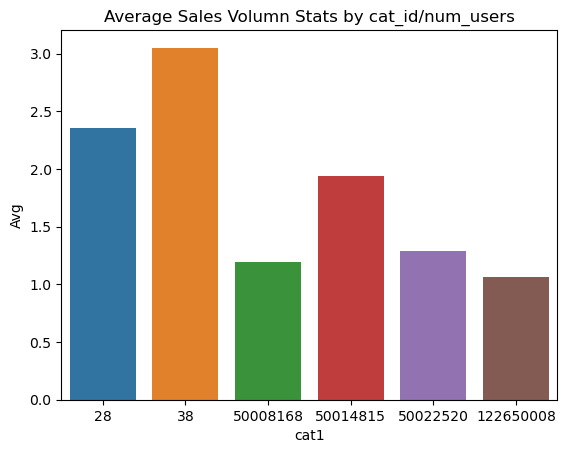

In [36]:
# 计算每个大类的人均销量情况
avg_cat_stats = (data_trade_info.groupby("cat1")['buy_mount'].sum() / data_trade_info.groupby("cat1")['user_id'].nunique())
sns.barplot(x=avg_cat_stats.index, y=avg_cat_stats.values)
plt.title("Average Sales Volumn Stats by cat_id/num_users")
plt.xlabel("cat1")
plt.ylabel("Avg")
plt.show()

大类28和50008168销量最佳，大类38虽然销量低、子类数最少但是人均购买量却很高，说明用户在购买38大类下的产品时选择余地较少，但同时用户对此类产品的需求又很旺盛，可以适量的增加大类38下的子类产品，提高销售量。12265008产品的销量、人均需求量都不高。说明用户对这类产品的需求低，建议减少进货，以免库存积压。

### 2.3 婴儿性别与销量的关系分析

In [39]:
# 将data_baby_info与data_trade_info进行联结
data_merge = pd.merge(data_trade_info, data_baby_info)
data_merge

,user_id,auction_id,cat_id,cat1,buy_mount,day,year,quarter,month,birthday,gender
0,513441334,19909384116,50010557,50008168,1,2012-12-12,2012,4,12,2011-01-05,1
1,377550424,15771663914,50015841,28,1,2012-11-23,2012,4,11,2011-06-20,1
2,47342027,14066344263,50013636,50008168,1,2012-09-11,2012,3,9,2010-10-08,1
3,119784861,20796936076,50140021,50008168,1,2012-11-29,2012,4,11,2012-03-27,0
4,159129426,15198386301,50013711,50008168,2,2012-08-08,2012,3,8,2010-08-25,0
...,...,...,...,...,...,...,...,...,...,...,...
796,379910739,12881672070,50012451,50008168,2,2012-09-04,2012,3,9,2011-02-26,0
797,685332320,12781785338,50018831,50014815,2,2013-06-01,2013,2,6,2012-02-23,0
798,389326420,17164967407,50006820,28,1,2014-09-16,2014,3,9,2013-07-17,0
799,1372572,16915013171,50008845,28,1,2013-03-27,2013,1,3,2012-01-30,1


In [41]:
# 计算婴儿的年龄
data_merge["age"] = round((data_merge["day"] - data_merge["birthday"])/pd.Timedelta(days = 365), 2)
data_merge

,user_id,auction_id,cat_id,cat1,buy_mount,day,year,quarter,month,birthday,gender,age
0,513441334,19909384116,50010557,50008168,1,2012-12-12,2012,4,12,2011-01-05,1,1.94
1,377550424,15771663914,50015841,28,1,2012-11-23,2012,4,11,2011-06-20,1,1.43
2,47342027,14066344263,50013636,50008168,1,2012-09-11,2012,3,9,2010-10-08,1,1.93
3,119784861,20796936076,50140021,50008168,1,2012-11-29,2012,4,11,2012-03-27,0,0.68
4,159129426,15198386301,50013711,50008168,2,2012-08-08,2012,3,8,2010-08-25,0,1.96
...,...,...,...,...,...,...,...,...,...,...,...,...
796,379910739,12881672070,50012451,50008168,2,2012-09-04,2012,3,9,2011-02-26,0,1.52
797,685332320,12781785338,50018831,50014815,2,2013-06-01,2013,2,6,2012-02-23,0,1.27
798,389326420,17164967407,50006820,28,1,2014-09-16,2014,3,9,2013-07-17,0,1.17
799,1372572,16915013171,50008845,28,1,2013-03-27,2013,1,3,2012-01-30,1,1.16


In [42]:
data_merge.age.describe()

count    801.000000
mean       1.205106
std        1.267036
min       -2.090000
25%        0.250000
50%        0.980000
75%        2.080000
max        4.840000
Name: age, dtype: float64

婴儿最小年龄竟然存在负数，这是不符合逻辑的，需要清除。

In [44]:
data_merge = data_merge[data_merge.age > 0]
data_merge.age.describe()

count    663.000000
mean       1.537979
std        1.122517
min        0.020000
25%        0.590000
50%        1.250000
75%        2.300000
max        4.840000
Name: age, dtype: float64

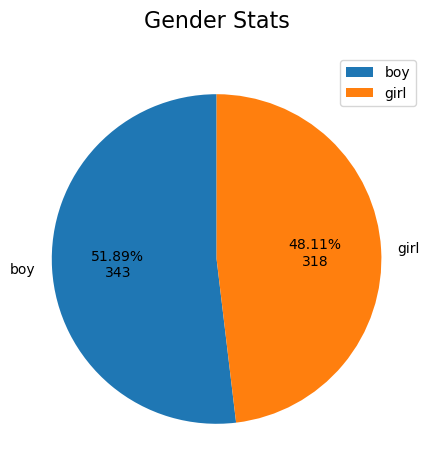

In [51]:
# 统计婴儿性别比例
import numpy as np
# 计算比例函数
def compute_fraction(pct, allvals):
    absolute = int(pct/100 * np.sum(allvals))
    return '{:.2f}%\n{:d}'.format(pct, absolute)

gender_stats = data_merge.groupby(by = "gender")["user_id"].nunique()

labels=['boy','girl']
values=np.array([gender_stats[0], gender_stats[1]])

fig=plt.figure()
sub=fig.add_subplot(111)
sub.pie(values, labels=labels, startangle=90, autopct=lambda x: compute_fraction(x,values))
sub.legend()
fig.suptitle('Gender Stats',fontsize=16)
fig.tight_layout()
plt.show()

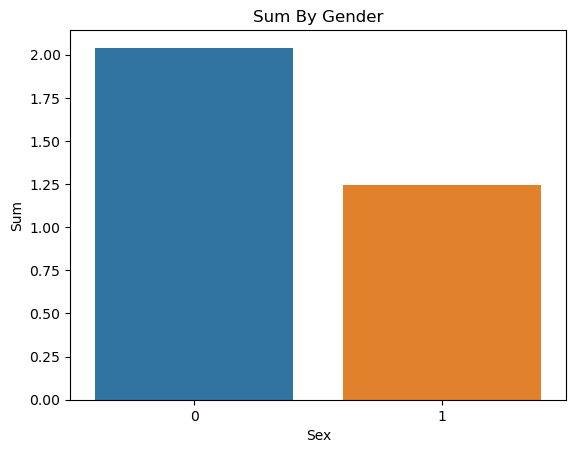

In [58]:
# 根据性别查看总销量
sum_by_gender = (data_merge.groupby("gender")['buy_mount'].sum() / data_merge.groupby(by = "gender")["user_id"].nunique())
sns.barplot(x=sum_by_gender.index, y=sum_by_gender.values)
plt.title("Sum By Gender")
plt.xlabel("Sex")
plt.ylabel("Sum")
plt.show()

可见男孩家庭的平均购买量大于女孩家庭。

In [52]:
# 各大类商品在性别上的销量
# 男孩
data_boy = data_merge[data_merge.gender == 0]
boy_stats = data_boy.groupby(by="cat1")["buy_mount"].sum()
boy_stats

cat1
28           112
38            94
50008168     154
50014815     303
50022520      14
122650008     23
Name: buy_mount, dtype: int64

Text(0.5, 0.98, 'Sales Volumn by Boy')

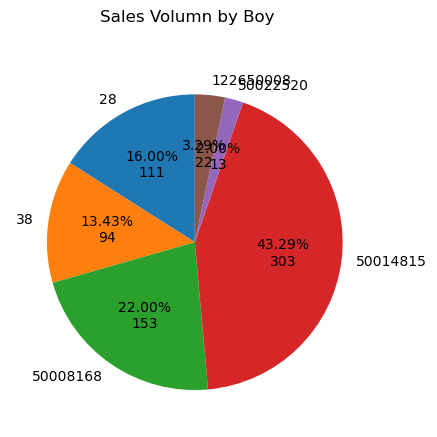

In [53]:
cat1_list = [28, 38, 50008168, 50014815, 50022520, 122650008]
values = np.array([boy_stats.loc[category] for category in cat1_list])

fig=plt.figure()
sub=fig.add_subplot(111)
sub.pie(values, labels=cat1_list, startangle=90, autopct=lambda x: compute_fraction(x,values))
fig.suptitle('Sales Volumn by Boy')

In [54]:
# 女孩
data_girl = data_merge[data_merge.gender == 1]
girl_stats = data_girl.groupby(by="cat1")["buy_mount"].sum()
girl_stats

cat1
28            81
38            37
50008168     158
50014815      87
50022520      14
122650008     19
Name: buy_mount, dtype: int64

Text(0.5, 0.98, 'Sales Volumn by Girl')

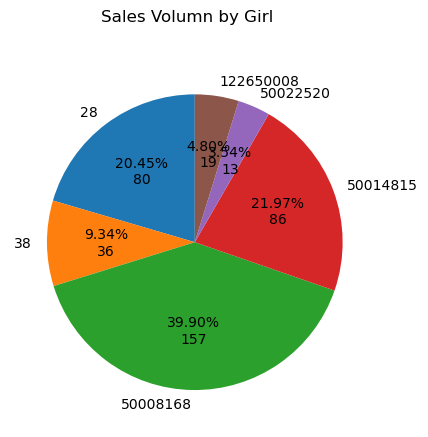

In [55]:
values = np.array([girl_stats.loc[category] for category in cat1_list])

fig=plt.figure()
sub=fig.add_subplot(111)
sub.pie(values, labels=cat1_list, startangle=90, autopct=lambda x: compute_fraction(x,values))
fig.suptitle('Sales Volumn by Girl')

可以看出，男、女两类婴幼儿用户的购买类别比例还是有较为明显的区别。

## 总结

### 产品销售情况
+ 母婴产品销量呈逐年增长趋势，但是每月的波动幅度较大。
+ 每年受春节影响，第一季度的销量会出现全年低点；在双十一及双十二等活动促销下，第四季度销量会达到全年峰值。
+ 50014815、50008168和28是热销大类TOP3
+ 大类38虽然销量少但是人均用户购买量却很大，可以考虑在该大类下新增子类，增加用户选择，提高销量。

### 用户画像
+ 男女婴儿家庭比例接近，但是男婴家庭的购买量明显大于女婴家庭。
+ 部分商品（50014815、50008168）男婴和女婴家庭购买比例差别明显。可对该类商品进行个性化推荐。

### 建议
+ 在临近春节前一个星期应该减少产品推广投入，减少进货量，保留低量库存；双十一及双十二预热阶段需要加大力度推广，丰富运营活动，吸引更多的客流量。同时，要增加产品库存，保证稳定货物供应。要增加客服人员，及时与物流联系，保证能够及时解答用户疑问并提高出货效率，提高用户购买体验。
+ 女婴家庭购买量低于男婴家庭，但是女婴与男婴的比例相差不大，建议多推广专为女婴设计的产品，提高女婴家庭的购买量。
+ 要扩充各大类下的子类产品，特别是大类38，增加用户选择，提高子类商品销量，进而提高大类销量。
+ 减少12265008大类下的产品进货，以免库存积压。